 - Pilot: 
 - Copilot: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

<ipython-input-1-2f841970d076>:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


## Bicicletas

Intentamos entender qué variables pueden afectar a la demanda de un sistema de alquiler de bicicletas. 

La variable objetivo es \texttt{cnt}, el número total de alquileres, y las posibles variables explicativas son

- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2018, 1:2019)
- mnth : month ( 1 to 12)
- holiday : weather day is holiday or not
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit :
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- temp : Normalized temperature in Celsius.
- atemp: Normalized feeling temperature in Celsius.
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- cnt: count of total rental bikes including both casual and registered 

In [2]:
bikes = pd.read_csv('bikesharing.csv')
bikes

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0          1  01-01-2018       1   0     1        0        1           1   
1          2  02-01-2018       1   0     1        0        2           1   
2          3  03-01-2018       1   0     1        0        3           1   
3          4  04-01-2018       1   0     1        0        4           1   
4          5  05-01-2018       1   0     1        0        5           1   
..       ...         ...     ...  ..   ...      ...      ...         ...   
725      726  27-12-2019       1   1    12        0        5           1   
726      727  28-12-2019       1   1    12        0        6           0   
727      728  29-12-2019       1   1    12        0        0           0   
728      729  30-12-2019       1   1    12        0        1           1   
729      730  31-12-2019       1   1    12        0        2           1   

     weathersit       temp     atemp      hum  windspeed  casual  registered  \
0             2  14.110847  18.18125  80.5833  10.749882     331         654   
1             2  14.902598  17.68695  69.6087  16.652113     131         670   
2             1   8.050924   9.47025  43.7273  16.636703     120        1229   
3             1   8.200000  10.60610  59.0435  10.739832     108        1454   
4             1   9.305237  11.46350  43.6957  12.522300      82        1518   
..          ...        ...       ...      ...        ...     ...         ...   
725           2  10.420847  11.33210  65.2917  23.458911     247        1867   
726           2  10.386653  12.75230  59.0000  10.416557     644        2451   
727           2  10.386653  12.12000  75.2917   8.333661     159        1182   
728           1  10.489153  11.58500  48.3333  23.500518     364        1432   
729           2   8.849153  11.17435  57.7500  10.374682     439        2290   

      cnt  
0     985  
1     801  
2    1349  
3    1562  
4    1600  
..    ...  
725  2114  
726  3095  
727  1341  
728  1796  
729  2729  

[730 rows x 16 columns]

Como las entradas están desordenadas, el siguiente código introduce el número de días desde la puesta en marcha del servicio. Observamos que el segundo la adopción fue mayor...

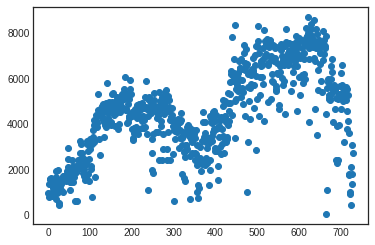

In [3]:
# No le prestes mucha atención: no vamos a usar este código...
bikes['dt'] = pd.to_datetime(bikes.dteday, dayfirst=True)
start = bikes.dt.min()
bikes['days'] = (bikes.dt - start).transform(lambda s:s.days)
plt.scatter(bikes.days, bikes.cnt)

Por este motivo, vamos a estudiar únicamente el rendimiento del servicio durante el último año

## Ejercicio 1

 - Construye un DataFrame que contenga sólo los registros del último año de funcionamiento.
 - Realiza un análisis exploratorio. 
     + Haz un scatter plot de `temp` contra `atemp` y comenta el resultado.
     + Indica qué variables deberían ser categóricas y cuáles de ellas parecen numéricas pero deberían ser tratadas como variables categóricas.
 - Elige un modelo de regresión lineal múltiple comparando al menos 3 modelos razonables. _Justifica las decisiones tomadas_.

## Extensión de los casquetes de hielo

Cargamos el conjunto ``seaice.csv``, sobre la extensión del hielo polar.

In [4]:
ice = pd.read_csv('seaice.csv')
ice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23860 entries, 0 to 23859
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         23860 non-null  int64  
 1   Month        23860 non-null  int64  
 2   Day          23860 non-null  int64  
 3   Extent       23860 non-null  float64
 4   Missing      23860 non-null  float64
 5   Source Data  23860 non-null  object 
 6   hemisphere   23860 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 1.3+ MB


In [5]:
ice.tail()

Year  Month  Day  Extent  Missing  \
23855  2015     12   27   8.358      0.0   
23856  2015     12   28   8.098      0.0   
23857  2015     12   29   7.791      0.0   
23858  2015     12   30   7.494      0.0   
23859  2015     12   31   7.222      0.0   

                                             Source Data hemisphere  
23855  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      south  
23856  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      south  
23857  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      south  
23858  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      south  
23859  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      south

Dibujamos la extensión de hielo polar (`Extent`) y observamos que el conjunto de datos parece tener dos partes diferenciadas:

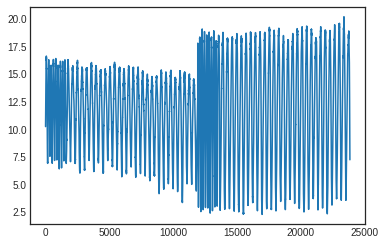

In [6]:
plt.plot(ice['Extent'])

In [7]:
ice.describe(include='all')

Year         Month           Day        Extent  Missing  \
count   23860.000000  23860.000000  23860.000000  23860.000000  23860.0   
unique           NaN           NaN           NaN           NaN      NaN   
top              NaN           NaN           NaN           NaN      NaN   
freq             NaN           NaN           NaN           NaN      NaN   
mean     1998.851635      6.550293     15.742917     11.603068      0.0   
std         9.951976      3.447684      8.802258      4.586068      0.0   
min      1978.000000      1.000000      1.000000      2.264000      0.0   
25%      1991.000000      4.000000      8.000000      7.747750      0.0   
50%      1999.000000      7.000000     16.000000     12.297000      0.0   
75%      2007.000000     10.000000     23.000000     15.197250      0.0   
max      2015.000000     12.000000     31.000000     20.201000      0.0   

                                              Source Data hemisphere  
count                                               23860      23860  
unique                                              23860          2  
top     ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north  
freq                                                    1      11930  
mean                                                  NaN        NaN  
std                                                   NaN        NaN  
min                                                   NaN        NaN  
25%                                                   NaN        NaN  
50%                                                   NaN        NaN  
75%                                                   NaN        NaN  
max                                                   NaN        NaN

Observando las variables regresoras vemos que `hemisphere` sólo toma dos valores, y nos limitamos a estudiar el casquete del polo norte.

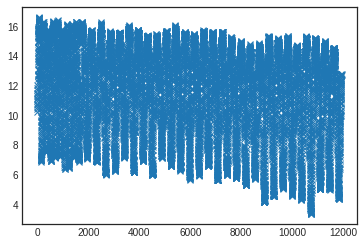

In [8]:
icen = ice[ice['hemisphere']=='north']
plt.plot(icen['Extent'],'x')

Observamos las primeras y las últimas entradas de `icen`:

In [9]:
icen.head()

Year  Month  Day  Extent  Missing  \
0  1978     10   26  10.231      0.0   
1  1978     10   28  10.420      0.0   
2  1978     10   30  10.557      0.0   
3  1978     11    1  10.670      0.0   
4  1978     11    3  10.777      0.0   

                                         Source Data hemisphere  
0  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north  
1  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north  
2  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north  
3  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north  
4  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north

In [10]:
icen.tail()

Year  Month  Day  Extent  Missing  \
11925  2015     12   27  12.680      0.0   
11926  2015     12   28  12.745      0.0   
11927  2015     12   29  12.762      0.0   
11928  2015     12   30  12.800      0.0   
11929  2015     12   31  12.735      0.0   

                                             Source Data hemisphere  
11925  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north  
11926  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north  
11927  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north  
11928  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north  
11929  ftp://sidads.colorado.edu/pub/DATASETS/nsidc00...      north

vemos que las entradas están ordenadas cronológicamente, una medición cada dos días al principio y una cada día al final.

Haciendo un poco de zoom vemos un patrón estacional muy fuerte, que no deja ver la tendencia a largo plazo

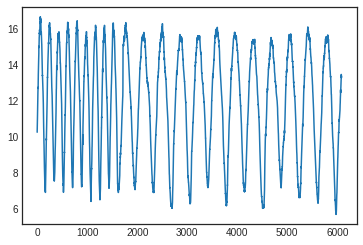

In [11]:
icen2000 = ice[(ice['hemisphere']=='north') & (ice['Year'] < 2000)]
plt.plot(icen2000['Extent'])

Si seleccionamos un único mes del año, entonces se aprecia la tendencia descendiente del hielo.

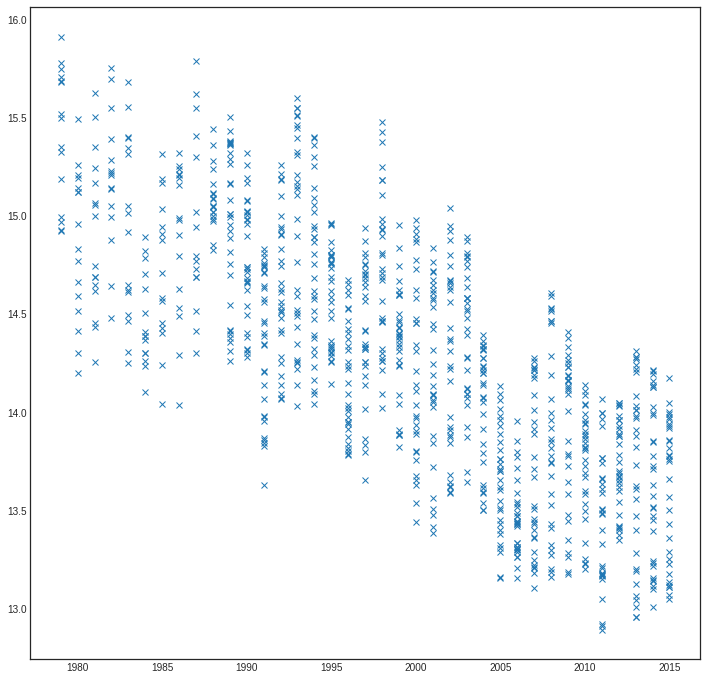

In [12]:
icenM = ice[(ice['hemisphere']=='north') & (ice['Month']==1)]
plt.figure(figsize=(12,12))
plt.plot(icenM['Year'], icenM['Extent'], 'x')

Otra forma distinta de capturar la tendencia es usar regresión. Pero un modelo `Extent ~ Year` da un resultado muy malo, porque la variación de un año a otro es pequeña comparada con la variación interanual.

In [13]:
est = smf.ols('Extent ~ Year', icen).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Extent   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     329.7
Date:                Sat, 27 May 2023   Prob (F-statistic):           1.06e-72
Time:                        21:22:53   Log-Likelihood:                -30792.
No. Observations:               11930   AIC:                         6.159e+04
Df Residuals:                   11928   BIC:                         6.160e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    118.1817      5.879     20.102      0.000     106.658     129.706
Year          -0.0534      0.003    -18.158      0.000      -0.059      -0.048
==============================================================================
Omnibus:                     8026.070   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              979.123
Skew:                          -0.391   Prob(JB):                    2.43e-213
Kurtosis:                       1.835   Cond. No.                     4.01e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Es posible introducir una variable al cuadrado como variable regresora, e intentamos un modelo polinómico, de orden 2:

$$
    E = \beta_0 + \beta_{Y}\cdot Year + \beta_{Y,2}\cdot Year^2 + \varepsilon
$$

pero el modelo no es mejor:

In [14]:
est = smf.ols('Extent ~ Year + np.power(Year,2)', icen).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Extent   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     168.1
Date:                Sat, 27 May 2023   Prob (F-statistic):           1.01e-72
Time:                        21:22:53   Log-Likelihood:                -30789.
No. Observations:               11930   AIC:                         6.158e+04
Df Residuals:                   11927   BIC:                         6.161e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2894.4776   1194.924     -2.422      0.015   -5236.723    -552.232
Year                  2.9623      1.196      2.477      0.013       0.618       5.307
np.power(Year, 2)    -0.0008      0.000     -2.521      0.012      -0.001      -0.000
==============================================================================
Omnibus:                     8311.875   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              980.350
Skew:                          -0.389   Prob(JB):                    1.32e-213
Kurtosis:                       1.830   Cond. No.                     1.63e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Ejercicio 2

Para este ejercicio, usa únicamente los datos del hemisferio norte.

 - Elige un día de verano, selecciona sólo los datos de ese día para cada año estudiado, y ajusta un modelo de regresión lineal a la extensión del hielo para los datos de ese día.
 - Construye un modelo cuadrático con el año como variable explicativa, para el día de verano elegido. Compara los dos modelos.
 - Usa los dos modelos, lineal y cuadrático, para extrapolar la extensión del hielo en el Oceáno Ártico en Agosto de 2030, 2040 y 2050.
 - Compara tus predicciones con las obtenidas de ajustar un modelo `'Extent ~ Year + np.power(Year,2) + C(Month)'` para todos los registros del polo norte.